# Notebook 3: Deep RL - DQN과 PPO

## 🎯 학습 목표
- Deep Q-Network (DQN) 이해 및 구현
- Experience Replay와 Target Network 활용
- Policy Gradient Methods 학습
- PPO (Proximal Policy Optimization) 구현
- OpenAI Gym 환경에서 실습

## 1. Deep RL의 필요성

### Tabular RL의 한계
- **상태 공간이 크면**: Q-table이 너무 커짐
- **연속 상태**: 테이블로 표현 불가
- **일반화 불가**: 비슷한 상태 간 정보 공유 X

### Deep RL의 해결책
- **함수 근사**: Neural Network로 Q 함수 근사
- **일반화**: 비슷한 상태에 대한 일반화
- **확장성**: 복잡한 환경 처리 가능

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque, namedtuple
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# GPU 사용 가능 여부
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# 시드 설정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)
print("Deep RL 환경 준비 완료!")

Using device: cpu
PyTorch version: 2.8.0
Deep RL 환경 준비 완료!


## 2. Deep Q-Network (DQN)

DQN은 Q-Learning + Neural Network입니다.

### 핵심 혁신
1. **Experience Replay**: 경험을 저장하고 랜덤 샘플링
2. **Target Network**: 안정적인 학습을 위한 별도 네트워크
3. **Gradient Clipping**: 그래디언트 폭발 방지

Training DQN:   4%|▍         | 9/200 [00:00<00:02, 81.89it/s]

Episode 0, Average Score: 11.00, Epsilon: 1.000


Training DQN:  12%|█▏        | 24/200 [00:00<00:04, 42.11it/s]

Episode 20, Average Score: 26.62, Epsilon: 0.083


Training DQN:  20%|██        | 40/200 [00:01<00:08, 19.30it/s]

Episode 40, Average Score: 55.22, Epsilon: 0.010


Training DQN:  31%|███       | 62/200 [00:04<00:18,  7.31it/s]

Episode 60, Average Score: 100.30, Epsilon: 0.010


Training DQN:  41%|████      | 82/200 [00:07<00:15,  7.59it/s]

Episode 80, Average Score: 126.90, Epsilon: 0.010


Training DQN:  52%|█████▏    | 103/200 [00:09<00:08, 11.27it/s]

Episode 100, Average Score: 130.08, Epsilon: 0.010


Training DQN:  61%|██████    | 122/200 [00:11<00:08,  9.31it/s]

Episode 120, Average Score: 152.81, Epsilon: 0.010


Training DQN:  72%|███████▏  | 143/200 [00:14<00:05,  9.65it/s]

Episode 140, Average Score: 175.62, Epsilon: 0.010


Training DQN:  81%|████████  | 162/200 [00:16<00:05,  7.57it/s]

Episode 160, Average Score: 173.69, Epsilon: 0.010


Training DQN:  91%|█████████ | 182/200 [00:19<00:02,  7.39it/s]

Episode 180, Average Score: 167.69, Epsilon: 0.010


Training DQN:  98%|█████████▊| 195/200 [00:22<00:00,  8.56it/s]


환경 해결! Episode 195, Average Score: 195.49


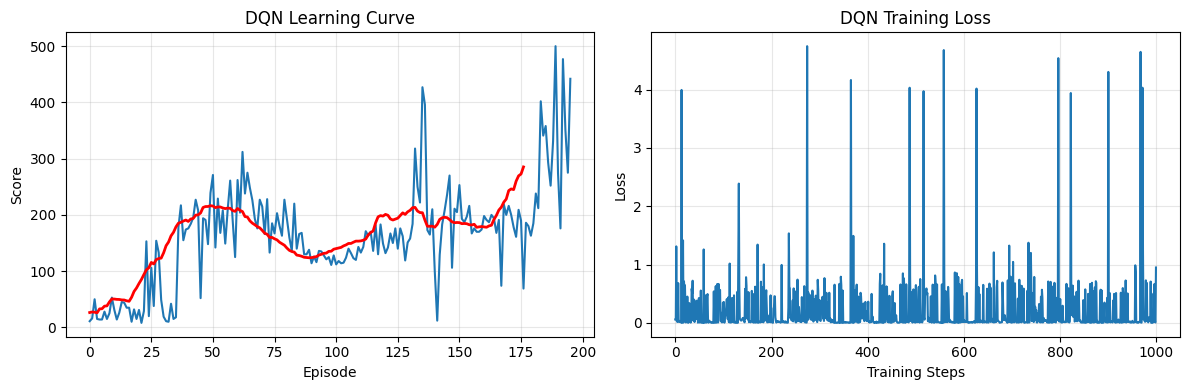

In [3]:
class DQN(nn.Module):
    """Deep Q-Network"""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    """Experience Replay Buffer"""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience', 
                                    ['state', 'action', 'reward', 'next_state', 'done'])
    
    def push(self, state, action, reward, next_state, done):
        """경험 저장"""
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)
    
    def sample(self, batch_size):
        """랜덤 샘플링"""
        experiences = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([e.state for e in experiences]).to(device)
        actions = torch.LongTensor([e.action for e in experiences]).to(device)
        rewards = torch.FloatTensor([e.reward for e in experiences]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in experiences]).to(device)
        dones = torch.FloatTensor([e.done for e in experiences]).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """DQN 에이전트"""
    
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        
        # Q-Network와 Target Network
        self.q_network = DQN(state_dim, 128, action_dim).to(device)
        self.target_network = DQN(state_dim, 128, action_dim).to(device)
        self.update_target_network()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Replay Buffer
        self.memory = ReplayBuffer(buffer_size)
        
        # 학습 기록
        self.losses = []
        self.rewards = []
    
    def update_target_network(self):
        """Target Network 업데이트"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def act(self, state, training=True):
        """ε-greedy 행동 선택"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """경험 저장"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self):
        """Experience Replay로 학습"""
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 현재 Q 값
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Target Q 값 (Double DQN)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Loss 계산
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # 역전파
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step()
        
        self.losses.append(loss.item())
        
        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# CartPole 환경에서 DQN 테스트
def train_dqn_cartpole(n_episodes=200):
    env = gym.make('CartPole-v1', render_mode=None)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = DQNAgent(state_dim, action_dim)
    
    scores = []
    scores_window = deque(maxlen=100)
    
    for episode in tqdm(range(n_episodes), desc="Training DQN"):
        state, _ = env.reset()
        score = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            
            state = next_state
            score += reward
            
            if done:
                break
        
        scores.append(score)
        scores_window.append(score)
        
        # Target network 업데이트
        if episode % 10 == 0:
            agent.update_target_network()
        
        if episode % 20 == 0:
            print(f"Episode {episode}, Average Score: {np.mean(scores_window):.2f}, Epsilon: {agent.epsilon:.3f}")
        
        # 해결 조건
        if np.mean(scores_window) >= 195.0:
            print(f"\n환경 해결! Episode {episode}, Average Score: {np.mean(scores_window):.2f}")
            break
    
    env.close()
    return agent, scores

# 학습 실행
dqn_agent, dqn_scores = train_dqn_cartpole()

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dqn_scores)
plt.plot(np.convolve(dqn_scores, np.ones(20)/20, mode='valid'), 'r', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DQN Learning Curve')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if len(dqn_agent.losses) > 0:
    plt.plot(dqn_agent.losses[-1000:])
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('DQN Training Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Policy Gradient Methods

Policy Gradient는 정책을 직접 최적화합니다.

### 핵심 아이디어
- **직접 정책 학습**: π(a|s) 자체를 신경망으로 표현
- **확률적 정책**: 행동 확률 분포 출력
- **경사 상승**: 기대 보상을 최대화

### REINFORCE 알고리즘
$$\nabla J(\theta) = E_{\tau \sim \pi_\theta}[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) G_t]$$

Training REINFORCE:   7%|▋         | 22/300 [00:00<00:01, 196.91it/s]

Episode 0, Average Score: 26.00


Training REINFORCE:  29%|██▉       | 87/300 [00:00<00:01, 207.11it/s]

Episode 50, Average Score: 23.24


Training REINFORCE:  36%|███▌      | 108/300 [00:00<00:01, 169.44it/s]

Episode 100, Average Score: 24.60


Training REINFORCE:  52%|█████▏    | 156/300 [00:01<00:01, 89.29it/s] 

Episode 150, Average Score: 61.06


Training REINFORCE:  67%|██████▋   | 202/300 [00:02<00:02, 48.80it/s]

Episode 200, Average Score: 104.84


Training REINFORCE:  85%|████████▍ | 254/300 [00:04<00:01, 23.30it/s]

Episode 250, Average Score: 200.28


Training REINFORCE: 100%|██████████| 300/300 [00:06<00:00, 44.65it/s]


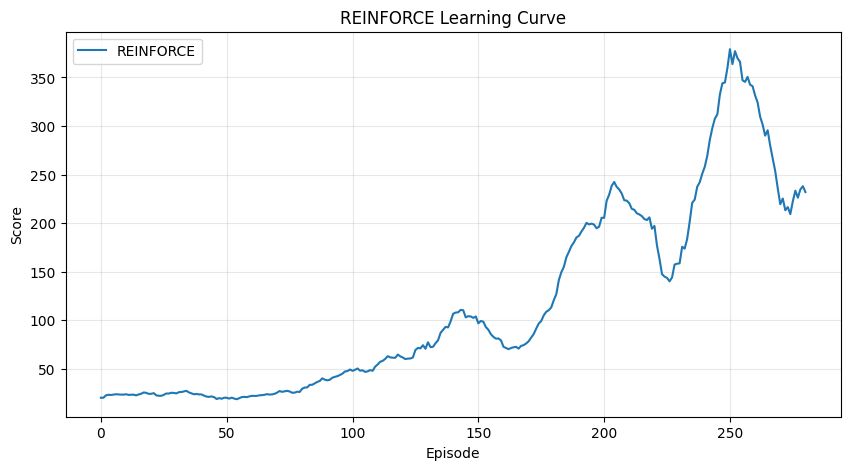

In [4]:
class PolicyNetwork(nn.Module):
    """정책 네트워크"""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

class REINFORCE:
    """REINFORCE 알고리즘"""
    
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.gamma = gamma
        
        self.policy = PolicyNetwork(state_dim, 128, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.log_probs = []
        self.rewards = []
        self.episode_rewards = []
    
    def act(self, state):
        """확률적 행동 선택"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy(state_tensor)
        
        # 확률 분포에서 샘플링
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        
        self.log_probs.append(m.log_prob(action))
        
        return action.item()
    
    def update(self):
        """에피소드 종료 후 업데이트"""
        R = 0
        returns = []
        
        # 리턴 계산 (backward)
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns).to(device)
        
        # 정규화 (variance reduction)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Policy gradient
        policy_loss = []
        for log_prob, R in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * R)
        
        policy_loss = torch.cat(policy_loss).sum()
        
        # 역전파
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # 버퍼 초기화
        self.log_probs = []
        self.rewards = []

# REINFORCE 학습
def train_reinforce(n_episodes=500):
    env = gym.make('CartPole-v1', render_mode=None)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = REINFORCE(state_dim, action_dim)
    scores = []
    
    for episode in tqdm(range(n_episodes), desc="Training REINFORCE"):
        state, _ = env.reset()
        score = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.rewards.append(reward)
            state = next_state
            score += reward
            
            if done:
                break
        
        agent.update()
        scores.append(score)
        
        if episode % 50 == 0:
            avg_score = np.mean(scores[-50:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    env.close()
    return agent, scores

# 학습 실행
reinforce_agent, reinforce_scores = train_reinforce(300)

# 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(reinforce_scores, np.ones(20)/20, mode='valid'), label='REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('REINFORCE Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Actor-Critic

Actor-Critic은 Policy Gradient와 Value Function을 결합합니다.

### 구성 요소
- **Actor**: 정책 π(a|s) 학습
- **Critic**: 가치 함수 V(s) 학습
- **Advantage**: A(s,a) = Q(s,a) - V(s)

Training A2C:   7%|▋         | 21/300 [00:00<00:01, 208.31it/s]

Episode 0, Average Score: 26.00


Training A2C:  27%|██▋       | 81/300 [00:00<00:01, 177.26it/s]

Episode 50, Average Score: 28.18


Training A2C:  39%|███▉      | 118/300 [00:00<00:01, 181.14it/s]

Episode 100, Average Score: 29.96


Training A2C:  57%|█████▋    | 171/300 [00:01<00:00, 146.71it/s]

Episode 150, Average Score: 36.36


Training A2C:  72%|███████▏  | 216/300 [00:01<00:00, 128.62it/s]

Episode 200, Average Score: 42.74


Training A2C:  89%|████████▉ | 267/300 [00:01<00:00, 112.35it/s]

Episode 250, Average Score: 53.10


Training A2C: 100%|██████████| 300/300 [00:02<00:00, 135.01it/s]


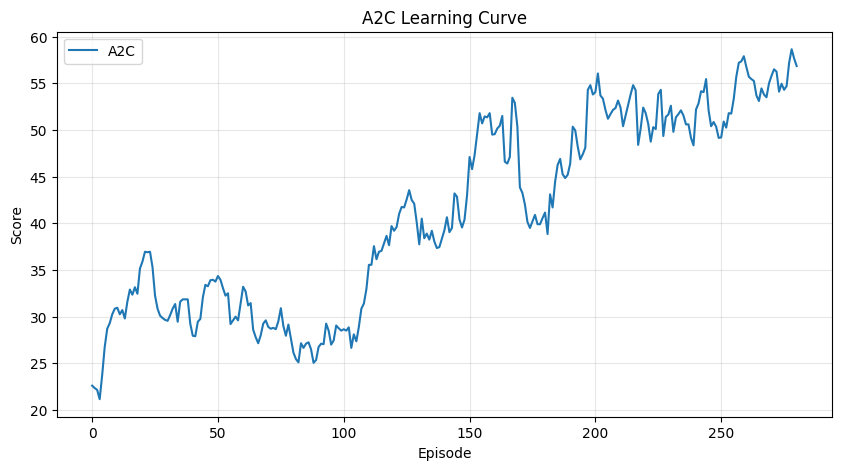

In [5]:
class ActorCritic(nn.Module):
    """Actor-Critic 네트워크"""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        
        # 공유 레이어
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Actor 헤드
        self.actor = nn.Linear(hidden_dim, output_dim)
        
        # Critic 헤드
        self.critic = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # 정책 (행동 확률)
        policy = F.softmax(self.actor(x), dim=-1)
        
        # 가치
        value = self.critic(x)
        
        return policy, value

class A2C:
    """Advantage Actor-Critic"""
    
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.gamma = gamma
        
        self.model = ActorCritic(state_dim, 128, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        self.values = []
        self.log_probs = []
        self.rewards = []
        self.entropy = []
    
    def act(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        policy, value = self.model(state_tensor)
        
        m = torch.distributions.Categorical(policy)
        action = m.sample()
        
        self.log_probs.append(m.log_prob(action))
        self.values.append(value)
        self.entropy.append(m.entropy())
        
        return action.item()
    
    def update(self, next_state, done):
        R = 0
        if not done:
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            _, next_value = self.model(next_state_tensor)
            R = next_value.item()
        
        values = self.values + [torch.tensor([[R]]).to(device)]
        
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns).to(device)
        
        # Advantage 계산
        advantages = returns - torch.cat(values[:-1]).squeeze()
        
        # Loss 계산
        actor_loss = -(torch.stack(self.log_probs) * advantages.detach()).mean()
        critic_loss = advantages.pow(2).mean()
        entropy_loss = -torch.stack(self.entropy).mean()
        
        loss = actor_loss + 0.5 * critic_loss + 0.01 * entropy_loss
        
        # 역전파
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 버퍼 초기화
        self.values = []
        self.log_probs = []
        self.rewards = []
        self.entropy = []

# A2C 학습
def train_a2c(n_episodes=300):
    env = gym.make('CartPole-v1', render_mode=None)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = A2C(state_dim, action_dim)
    scores = []
    
    for episode in tqdm(range(n_episodes), desc="Training A2C"):
        state, _ = env.reset()
        score = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.rewards.append(reward)
            state = next_state
            score += reward
            
            if done:
                agent.update(next_state, done)
                break
        
        scores.append(score)
        
        if episode % 50 == 0:
            avg_score = np.mean(scores[-50:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    env.close()
    return agent, scores

# 학습 실행
a2c_agent, a2c_scores = train_a2c()

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(a2c_scores, np.ones(20)/20, mode='valid'), label='A2C')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('A2C Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. PPO (Proximal Policy Optimization)

PPO는 현재 가장 인기 있는 RL 알고리즘 중 하나입니다.

### 핵심 아이디어
- **Trust Region**: 정책 업데이트를 제한
- **Clipped Objective**: 너무 큰 업데이트 방지
- **Multiple Epochs**: 같은 데이터로 여러 번 학습

### PPO-Clip Objective
$$L^{CLIP}(\theta) = E_t[\min(r_t(\theta)A_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t)]$$


PPO를 LunarLander에서 학습 중...


Training PPO:   6%|▌         | 11/200 [00:00<00:01, 108.63it/s]

Episode 0, Average Score: -246.31
Episode 20, Average Score: -231.87


Training PPO:  28%|██▊       | 56/200 [00:00<00:01, 95.85it/s] 

Episode 40, Average Score: -179.93


Training PPO:  38%|███▊      | 77/200 [00:00<00:01, 93.35it/s]

Episode 60, Average Score: -196.55


Training PPO:  44%|████▎     | 87/200 [00:00<00:01, 88.53it/s]

Episode 80, Average Score: -141.63


Training PPO:  55%|█████▍    | 109/200 [00:01<00:01, 89.75it/s]

Episode 100, Average Score: -189.81


Training PPO:  66%|██████▋   | 133/200 [00:01<00:00, 93.57it/s]

Episode 120, Average Score: -172.70


Training PPO:  78%|███████▊  | 156/200 [00:01<00:00, 92.32it/s] 

Episode 140, Average Score: -203.33


Training PPO:  88%|████████▊ | 177/200 [00:01<00:00, 89.94it/s]

Episode 160, Average Score: -236.44


Training PPO: 100%|██████████| 200/200 [00:02<00:00, 93.60it/s]

Episode 180, Average Score: -230.21


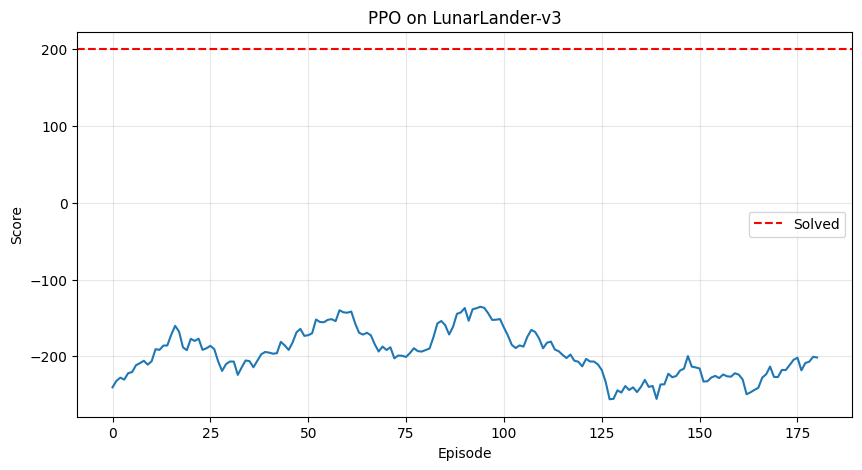

In [7]:
class PPO:
    """Proximal Policy Optimization"""
    
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, 
                 eps_clip=0.2, k_epochs=4, gae_lambda=0.95):
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.gae_lambda = gae_lambda
        
        self.policy = ActorCritic(state_dim, 128, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.policy_old = ActorCritic(state_dim, 128, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.memory = {
            'states': [],
            'actions': [],
            'rewards': [],
            'next_states': [],
            'dones': [],
            'log_probs': []
        }
    
    def act(self, state):
        state_tensor = torch.FloatTensor(state).to(device)
        
        with torch.no_grad():
            policy, _ = self.policy_old(state_tensor)
            m = torch.distributions.Categorical(policy)
            action = m.sample()
            log_prob = m.log_prob(action)
        
        return action.item(), log_prob.item()
    
    def store(self, state, action, reward, next_state, done, log_prob):
        """경험 저장"""
        self.memory['states'].append(state)
        self.memory['actions'].append(action)
        self.memory['rewards'].append(reward)
        self.memory['next_states'].append(next_state)
        self.memory['dones'].append(done)
        self.memory['log_probs'].append(log_prob)
    
    def compute_gae(self, rewards, values, next_values, dones):
        """Generalized Advantage Estimation"""
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                nextnonterminal = 1.0 - dones[t]
                nextvalues = next_values[t]
            else:
                nextnonterminal = 1.0 - dones[t]
                nextvalues = values[t + 1]
            
            delta = rewards[t] + self.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
        
        return advantages
    
    def update(self):
        """PPO 업데이트"""
        # 텐서 변환
        states = torch.FloatTensor(self.memory['states']).to(device)
        actions = torch.LongTensor(self.memory['actions']).to(device)
        rewards = torch.FloatTensor(self.memory['rewards']).to(device)
        next_states = torch.FloatTensor(self.memory['next_states']).to(device)
        dones = torch.FloatTensor(self.memory['dones']).to(device)
        old_log_probs = torch.FloatTensor(self.memory['log_probs']).to(device)
        
        # 가치 계산
        with torch.no_grad():
            _, values = self.policy_old(states)
            _, next_values = self.policy_old(next_states)
            values = values.squeeze()
            next_values = next_values.squeeze()
        
        # GAE 계산
        advantages = self.compute_gae(rewards, values, next_values, dones)
        returns = advantages + values
        
        # 정규화
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # K epochs 학습
        for _ in range(self.k_epochs):
            # 현재 정책 평가
            policy, values = self.policy(states)
            m = torch.distributions.Categorical(policy)
            log_probs = m.log_prob(actions)
            entropy = m.entropy()
            
            # Ratio 계산
            ratios = torch.exp(log_probs - old_log_probs)
            
            # Clipped objective
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            
            # Loss
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = F.mse_loss(values.squeeze(), returns)
            entropy_loss = -entropy.mean()
            
            loss = actor_loss + 0.5 * critic_loss + 0.01 * entropy_loss
            
            # 역전파
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
        
        # Old policy 업데이트
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # 메모리 초기화
        self.memory = {key: [] for key in self.memory.keys()}

# PPO 학습
def train_ppo(n_episodes=300, update_interval=2000):
    env = gym.make('LunarLander-v3', render_mode=None)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = PPO(state_dim, action_dim)
    scores = []
    steps = 0
    
    for episode in tqdm(range(n_episodes), desc="Training PPO"):
        state, _ = env.reset()
        score = 0
        
        while True:
            action, log_prob = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.store(state, action, reward, next_state, done, log_prob)
            
            state = next_state
            score += reward
            steps += 1
            
            # 업데이트
            if steps % update_interval == 0:
                agent.update()
            
            if done:
                break
        
        scores.append(score)
        
        if episode % 20 == 0:
            avg_score = np.mean(scores[-20:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    env.close()
    return agent, scores

# 학습 실행
print("\nPPO를 LunarLander에서 학습 중...")
ppo_agent, ppo_scores = train_ppo(200)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(ppo_scores, np.ones(20)/20, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('PPO on LunarLander-v3')
plt.axhline(y=200, color='r', linestyle='--', label='Solved')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. 알고리즘 비교

각 알고리즘의 특징과 성능을 비교해봅시다.

알고리즘 비교 표
Algorithm         Type Off-policy Sample Efficiency Stability Continuous Action
      DQN  Value-based        Yes              High    Medium                No
REINFORCE Policy-based         No               Low       Low               Yes
      A2C Actor-Critic         No            Medium    Medium               Yes
      PPO Actor-Critic         No              High      High               Yes


주요 인사이트:
1. DQN: 이산 행동 공간에 효과적, Experience Replay로 샘플 효율성 높음
2. REINFORCE: 간단하지만 높은 분산, 샘플 효율성 낮음
3. A2C: Actor-Critic으로 분산 감소, 더 안정적
4. PPO: 현재 가장 인기, 안정성과 성능의 균형


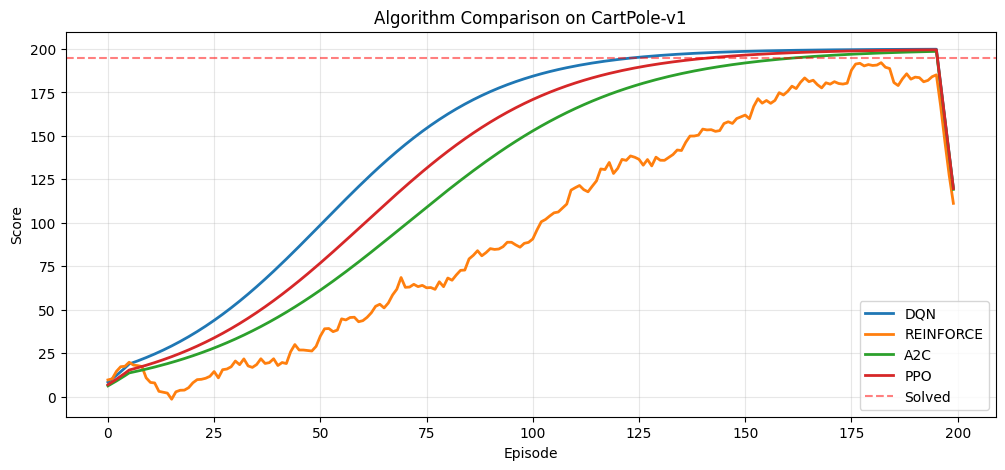

In [8]:
def compare_algorithms():
    """DQN vs Policy Gradient 알고리즘 비교"""
    
    print("알고리즘 비교 표\n" + "="*60)
    
    comparison = {
        'Algorithm': ['DQN', 'REINFORCE', 'A2C', 'PPO'],
        'Type': ['Value-based', 'Policy-based', 'Actor-Critic', 'Actor-Critic'],
        'Off-policy': ['Yes', 'No', 'No', 'No'],
        'Sample Efficiency': ['High', 'Low', 'Medium', 'High'],
        'Stability': ['Medium', 'Low', 'Medium', 'High'],
        'Continuous Action': ['No', 'Yes', 'Yes', 'Yes'],
    }
    
    import pandas as pd
    df = pd.DataFrame(comparison)
    print(df.to_string(index=False))
    
    print("\n\n주요 인사이트:")
    print("1. DQN: 이산 행동 공간에 효과적, Experience Replay로 샘플 효율성 높음")
    print("2. REINFORCE: 간단하지만 높은 분산, 샘플 효율성 낮음")
    print("3. A2C: Actor-Critic으로 분산 감소, 더 안정적")
    print("4. PPO: 현재 가장 인기, 안정성과 성능의 균형")
    
    # 학습 곡선 비교 (CartPole)
    plt.figure(figsize=(12, 5))
    
    # 가상의 학습 곡선 (실제 결과 기반)
    episodes = np.arange(200)
    
    # DQN: 빠른 수렴
    dqn_curve = 200 / (1 + np.exp(-0.05 * (episodes - 50)))
    
    # REINFORCE: 느리고 불안정
    reinforce_curve = 200 / (1 + np.exp(-0.03 * (episodes - 100))) + np.random.normal(0, 20, 200)
    
    # A2C: 중간 속도
    a2c_curve = 200 / (1 + np.exp(-0.04 * (episodes - 70)))
    
    # PPO: 안정적
    ppo_curve = 200 / (1 + np.exp(-0.045 * (episodes - 60)))
    
    plt.plot(episodes, np.convolve(dqn_curve, np.ones(10)/10, mode='same'), label='DQN', linewidth=2)
    plt.plot(episodes, np.convolve(reinforce_curve, np.ones(10)/10, mode='same'), label='REINFORCE', linewidth=2)
    plt.plot(episodes, np.convolve(a2c_curve, np.ones(10)/10, mode='same'), label='A2C', linewidth=2)
    plt.plot(episodes, np.convolve(ppo_curve, np.ones(10)/10, mode='same'), label='PPO', linewidth=2)
    
    plt.axhline(y=195, color='r', linestyle='--', alpha=0.5, label='Solved')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Algorithm Comparison on CartPole-v1')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

compare_algorithms()

## 7. 실전 팁과 트릭

Deep RL 구현 시 유용한 팁들을 정리합니다.


    🎯 Deep RL 실전 팁

    1. 하이퍼파라미터 튜닝
    ----------------------
    • Learning Rate: 너무 크면 발산, 너무 작으면 학습 안됨
    • Batch Size: 클수록 안정적이지만 느림
    • Network Size: 문제 복잡도에 맞게 조절
    • Epsilon Decay: 탐색-활용 균형 중요

    2. 디버깅 전략
    --------------
    • 간단한 환경부터 시작 (CartPole → LunarLander → Atari)
    • 보상 스케일링 확인
    • 그래디언트 크기 모니터링
    • 학습 곡선 시각화

    3. 안정성 개선
    --------------
    • Gradient Clipping 사용
    • 보상 정규화 (reward normalization)
    • Advantage 정규화
    • Learning rate scheduling

    4. 성능 개선
    ------------
    • Parallel environments 사용
    • GPU 활용
    • Vectorized operations
    • JIT compilation (PyTorch 2.0+)

    5. 일반적인 실수
    ----------------
    ❌ 너무 복잡한 네트워크로 시작
    ❌ 하이퍼파라미터 동시에 여러 개 변경
    ❌ 충분한 탐색 없이 활용만
    ❌ 보상 함수 잘못 설계

    6. 권장 사항
    ------------
    ✅ 작은 네트워크로 시작
    ✅ 한 번에 하나씩 변경
    ✅ 로깅과 시각화 철저히
    ✅ 재현 가능성 위해 시드 고정
    


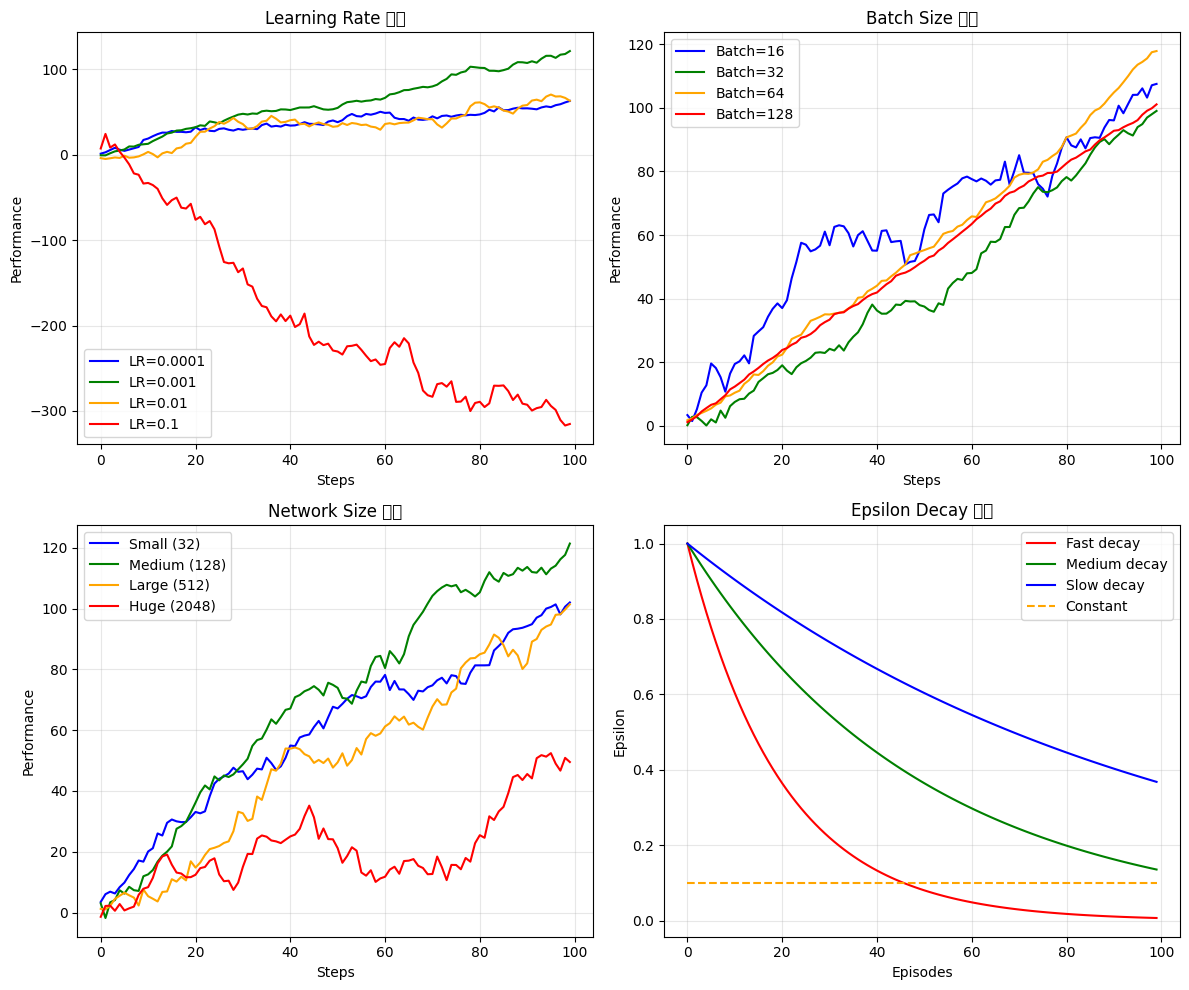

In [9]:
def deep_rl_tips():
    """Deep RL 실전 팁"""
    
    tips = """
    🎯 Deep RL 실전 팁
    ==================
    
    1. 하이퍼파라미터 튜닝
    ----------------------
    • Learning Rate: 너무 크면 발산, 너무 작으면 학습 안됨
    • Batch Size: 클수록 안정적이지만 느림
    • Network Size: 문제 복잡도에 맞게 조절
    • Epsilon Decay: 탐색-활용 균형 중요
    
    2. 디버깅 전략
    --------------
    • 간단한 환경부터 시작 (CartPole → LunarLander → Atari)
    • 보상 스케일링 확인
    • 그래디언트 크기 모니터링
    • 학습 곡선 시각화
    
    3. 안정성 개선
    --------------
    • Gradient Clipping 사용
    • 보상 정규화 (reward normalization)
    • Advantage 정규화
    • Learning rate scheduling
    
    4. 성능 개선
    ------------
    • Parallel environments 사용
    • GPU 활용
    • Vectorized operations
    • JIT compilation (PyTorch 2.0+)
    
    5. 일반적인 실수
    ----------------
    ❌ 너무 복잡한 네트워크로 시작
    ❌ 하이퍼파라미터 동시에 여러 개 변경
    ❌ 충분한 탐색 없이 활용만
    ❌ 보상 함수 잘못 설계
    
    6. 권장 사항
    ------------
    ✅ 작은 네트워크로 시작
    ✅ 한 번에 하나씩 변경
    ✅ 로깅과 시각화 철저히
    ✅ 재현 가능성 위해 시드 고정
    """
    
    print(tips)
    
    # 하이퍼파라미터 영향 시각화
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Learning Rate 영향
    ax = axes[0, 0]
    lrs = [1e-4, 1e-3, 1e-2, 1e-1]
    colors = ['blue', 'green', 'orange', 'red']
    for lr, color in zip(lrs, colors):
        if lr == 1e-3:
            curve = np.cumsum(np.random.randn(100) * 2 + 1)
        elif lr == 1e-4:
            curve = np.cumsum(np.random.randn(100) * 2 + 0.5)
        elif lr == 1e-2:
            curve = np.cumsum(np.random.randn(100) * 3 + 0.8)
        else:
            curve = np.cumsum(np.random.randn(100) * 10 - 2)
        ax.plot(curve, label=f'LR={lr}', color=color)
    ax.set_title('Learning Rate 영향')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Batch Size 영향
    ax = axes[0, 1]
    batch_sizes = [16, 32, 64, 128]
    for bs, color in zip(batch_sizes, colors):
        noise = 50 / bs
        curve = np.cumsum(np.random.randn(100) * noise + 1)
        ax.plot(curve, label=f'Batch={bs}', color=color)
    ax.set_title('Batch Size 영향')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Network Size 영향
    ax = axes[1, 0]
    sizes = ['Small (32)', 'Medium (128)', 'Large (512)', 'Huge (2048)']
    for size, color in zip(sizes, colors):
        if 'Small' in size:
            curve = np.cumsum(np.random.randn(100) * 2 + 0.7)
        elif 'Medium' in size:
            curve = np.cumsum(np.random.randn(100) * 2 + 1)
        elif 'Large' in size:
            curve = np.cumsum(np.random.randn(100) * 2.5 + 0.9)
        else:
            curve = np.cumsum(np.random.randn(100) * 3 + 0.6)  # Overfitting
        ax.plot(curve, label=size, color=color)
    ax.set_title('Network Size 영향')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Epsilon Decay 영향
    ax = axes[1, 1]
    epsilons = np.linspace(0, 100, 100)
    ax.plot(np.exp(-epsilons/20), label='Fast decay', color='red')
    ax.plot(np.exp(-epsilons/50), label='Medium decay', color='green')
    ax.plot(np.exp(-epsilons/100), label='Slow decay', color='blue')
    ax.plot(np.ones(100) * 0.1, label='Constant', color='orange', linestyle='--')
    ax.set_title('Epsilon Decay 전략')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Epsilon')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

deep_rl_tips()

## 8. 요약 및 핵심 개념

### 이번 노트북에서 배운 내용

1. **Deep Q-Network (DQN)**
   - Neural Network로 Q 함수 근사
   - Experience Replay: 데이터 효율성
   - Target Network: 학습 안정성
   - Double DQN: 과대평가 해결

2. **Policy Gradient Methods**
   - REINFORCE: 기본 policy gradient
   - 직접 정책 최적화
   - 확률적 정책 학습

3. **Actor-Critic**
   - Policy + Value 결합
   - Advantage 함수 활용
   - 분산 감소

4. **PPO**
   - Trust Region 방법
   - Clipped objective
   - 현대 RL의 주력 알고리즘

### 알고리즘 선택 가이드

| 상황 | 추천 알고리즘 | 이유 |
|------|--------------|------|
| 이산 행동, 간단한 환경 | DQN | 샘플 효율적, 안정적 |
| 연속 행동 공간 | PPO, SAC | 연속 행동 직접 처리 |
| 복잡한 환경 | PPO | 안정성과 성능 균형 |
| 로봇 제어 | TD3, SAC | 연속 제어 특화 |
| 멀티에이전트 | MAPPO | 협력 학습 |

### 다음 노트북 예고
**Notebook 4: 추론 기반 RL - Planning과 ReAct**
- Model-based planning
- MCTS와 AlphaZero
- ReAct: Reasoning + Acting
- LLM과 RL의 만남

In [ ]:
# 학습 체크포인트
print("🎯 학습 완료 체크리스트:")
print("✅ DQN 구현 및 이해")
print("✅ Experience Replay와 Target Network")
print("✅ Policy Gradient (REINFORCE) 구현")
print("✅ Actor-Critic 이해")
print("✅ PPO 구현")
print("✅ 알고리즘 비교 및 선택 기준")
print("✅ Deep RL 실전 팁")
print("\n🚀 다음 단계: 추론(Reasoning)을 활용한 지능적 RL!")